In [2]:
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
import sklearn.metrics as skm
import sys
sys.path.append("../../../ecg")

import load
import util
%matplotlib inline

In [3]:
model_path = "/deep/group/awni/ecg_models/default/1527627404-9/0.337-0.880-012-0.255-0.906.hdf5"
data_json = "../test.json"

preproc = util.load(os.path.dirname(model_path))
dataset = load.load_dataset(data_json)
ecgs, committee_labels = preproc.process(*dataset)

with open(data_json, 'r') as fid:
    committee_ids = [json.loads(l)['reviewer'] for l in fid]

revs = []
rev_ids = []
for i in range(6):
    with open("../test_rev{}.json".format(i), 'r') as fid:
        rev_info = [json.loads(l) for l in fid]
        revs.append([r['labels'] for r in rev_info])
        rev_ids.append([r['reviewer'] for r in rev_info])
        
revs = [preproc.process_y(r) for r in revs]

model = keras.models.load_model(model_path)
probs = model.predict(ecgs, verbose=1)

100%|██████████| 328/328 [00:00<00:00, 2028.70it/s]


328/328 [==============================] - 4s 13ms/step


In [50]:
#ame_ids = [i for i, c in enumerate(committee_ids) if c == [1,2,3]]
#ame_revs = [r[same_ids,...] for r in revs]
#same_grp = committee_labels[same_ids, ...]
#same_probs = probs[same_ids, ...]

same_revs = []
for rid in range(1, 10):
    ids = []
    r_labels = []
    for rev_id, rev in zip(rev_ids, revs):
        rids = [e for e, i in enumerate(rev_id) if i == rid]
        ids.extend(rids)
        r_labels.append(rev[rids, ...])
    same_revs.append((ids, r_labels))

In [51]:
def to_set(preds):
    idxs = np.argmax(preds, axis=2)
    return [list(set(r)) for r in idxs]

def set_stats(ground_truth, preds):
    labels = range(ground_truth.shape[2])
    ground_truth = to_set(ground_truth)
    preds = to_set(preds)
    stat_dict = {}
    for x in labels:
        tp = 0; fp = 0; fn = 0; tn = 0;
        for g, p in zip(ground_truth, preds):
            if x in g and x in p: # tp
                tp += 1
            if x not in g and x in p: # fp
                fp += 1
            if x in g and x not in p:
                fn += 1
            if x not in g and x not in p:
                tn += 1
        stat_dict[x] = (tp, fp, fn, tn)
    return stat_dict

def stats(ground_truth, preds):
    labels = range(ground_truth.shape[2])
    g = np.argmax(ground_truth, axis=2).ravel()
    p = np.argmax(preds, axis=2).ravel()
    stat_dict = {}
    for i in labels:
        # compute all the stats for each label
        tp = np.sum(g[g==i] == p[g==i])
        fp = np.sum(g[p==i] != p[p==i])
        fn = np.sum(g==i) - tp
        tn = np.sum(g!=i) - fp
        stat_dict[i] = (tp, fp, fn, tn)
    return stat_dict


stat_dicts = [set_stats(committee_labels[i,...], np.vstack(r)) for i, r in same_revs]
res_dict = {}
for k, v in stat_dicts[0].items():
    precisions = []
    recalls = []
    specificities = []
    for s in stat_dicts:
        tp, fp, fn, tn = s[k]
        precisions.append(tp / float(tp + fp))
        recalls.append(tp / float(tp + fn))
        specificities.append(tn / float(tn + fp))
    res_dict[preproc.int_to_class[k]] = {
         'precision' : precisions,
         'recall' : recalls,
         'specificity' : specificities}

In [52]:
def precision_recall_curve(ground_truth, human_res, probs, classes):
    gt = np.argmax(ground_truth, axis=2)
    if len(classes) == 3:
        f, ax = plt.subplots(1,3,figsize=(14,4))
    else:
        f, ax = plt.subplots(4,3,figsize=(14, 22))
        ax = [a for i in ax for a in i]
    for e, c in enumerate(classes):
        class_idx = preproc.class_to_int[c]
        
        binary_gt = gt == class_idx
        binary_probs = probs[..., class_idx]
        ppvs, senss, _ = skm.precision_recall_curve(binary_gt.ravel(), binary_probs.ravel())
        h_ppv, h_sens = human_res[c]['precision'], human_res[c]['recall']
        h_ppv, h_sens = np.array(h_ppv), np.array(h_sens)
        avg_sens, avg_ppv = np.mean(h_sens), np.mean(h_ppv)

        cax = ax[e]
        cax.plot(senss, ppvs, lw=2, label="Model")
        cax.plot(h_sens, h_ppv, 'r+', markersize=10, label="Individual Cardiologists")
        cax.plot(avg_sens, avg_ppv, 'go', markersize=6, label="Average Cardiologist")
        cax.set_xlim(0.0, 1.01)
        cax.set_ylim(0.0, 1.01)
        cax.set_title("Class {}".format(c))
        cax.set_xlabel('Sensitivity (Recall)')
        cax.set_ylabel('PPV (Precision)')
        cax.legend(loc=0)

    plt.savefig("human_model_prec_recall_curve.pdf",
       dpi=400,
       format='pdf',
       bbox_inches='tight')

def roc_curve(ground_truth, human_res, probs, classes,
              y_start, file_name):
    gt = np.argmax(ground_truth, axis=2)
    if len(classes) == 3:
        f, ax = plt.subplots(1,3,figsize=(14,4))
    else:
        f, ax = plt.subplots(4,3,figsize=(14, 22))
        ax = [a for i in ax for a in i]
    
    for e, c in enumerate(classes):
        class_idx = preproc.class_to_int[c]
        binary_gt = np.any(gt == class_idx, axis=1)
        binary_probs = np.max(probs[..., class_idx], axis=1)

        fps, tps, _ = skm.roc_curve(binary_gt.ravel(), binary_probs.ravel())
        h_fps, h_tps = human_res[c]['specificity'], human_res[c]['recall']
        h_fps, h_tps = 1 - np.array(h_fps), np.array(h_tps)
        avg_fps, avg_tps = np.mean(h_fps), np.mean(h_tps)
        cax = ax[e]
        cax.plot(fps, tps, lw=2, label="Model")
        cax.plot(h_fps, h_tps, 'r+', markersize=10, label="Individual Cardiologists")
        cax.plot(avg_fps, avg_tps, 'go', markersize=6, label="Average Cardiologist")
        cax.set_xlim(-0.008, 0.5)
        cax.set_ylim(y_start, 1.05)
        cax.set_title("Class {}".format(c))
        cax.set_xlabel('1 - Specificity')
        cax.set_ylabel('Sensitivity')
        cax.legend(loc=4)

    plt.savefig(file_name,
       dpi=400,
       format='pdf',
       bbox_inches='tight')

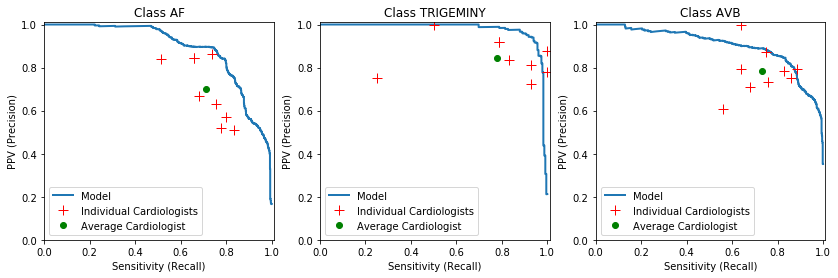

In [53]:
precision_recall_curve(committee_labels, res_dict, probs,
                       classes=["AF", "TRIGEMINY", "AVB"])

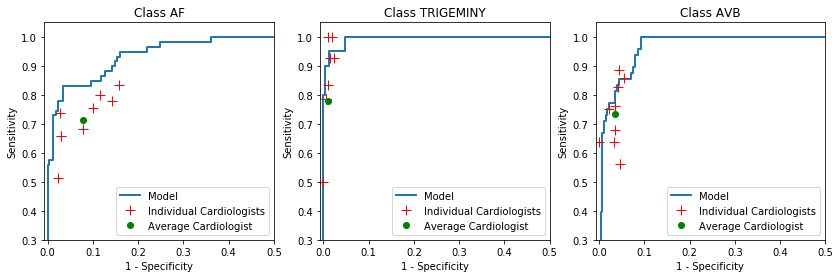

In [54]:
roc_curve(committee_labels, res_dict, probs,
          classes=["AF", "TRIGEMINY", "AVB"],
          y_start=0.3,
          file_name="human_model_roc.pdf")

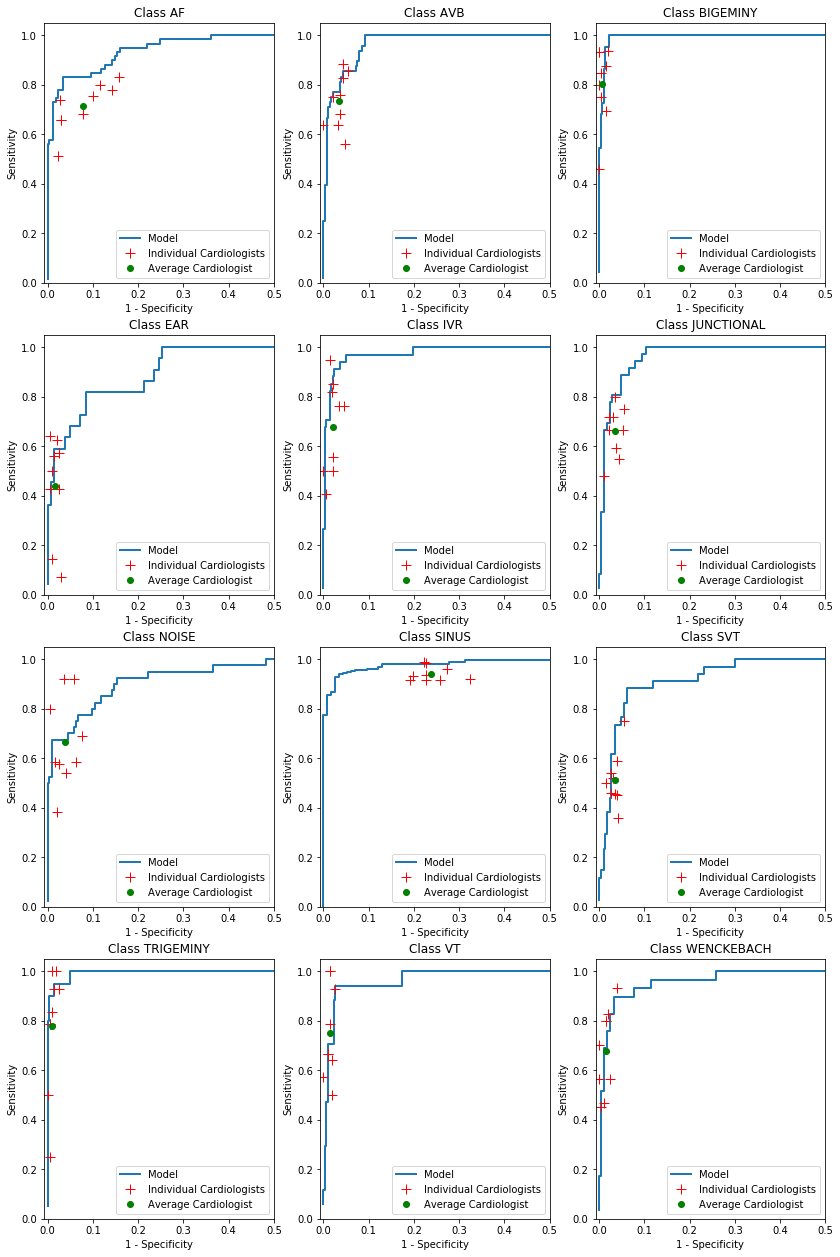

In [55]:
roc_curve(committee_labels, res_dict, probs,
          classes=preproc.classes,
          y_start=0.0,
          file_name="human_model_roc_all.pdf")